In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings

warnings.filterwarnings('ignore')

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


# Import Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score,classification_report,accuracy_score

from xgboost import XGBClassifier

# Load Data


In [60]:
# Load data
train = pd.read_csv('/kaggle/input/mobile-price-classification/train.csv')
test = pd.read_csv('/kaggle/input/mobile-price-classification/test.csv')
test.drop(columns='id', inplace=True)
train.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
5,1859,0,0.5,1,3,0,22,0.7,164,1,...,1004,1654,1067,17,1,10,1,0,0,1
6,1821,0,1.7,0,4,1,10,0.8,139,8,...,381,1018,3220,13,8,18,1,0,1,3
7,1954,0,0.5,1,0,0,24,0.8,187,4,...,512,1149,700,16,3,5,1,1,1,0
8,1445,1,0.5,0,0,0,53,0.7,174,7,...,386,836,1099,17,1,20,1,0,0,0
9,509,1,0.6,1,2,1,9,0.1,93,5,...,1137,1224,513,19,10,12,1,0,0,0


<AxesSubplot:>

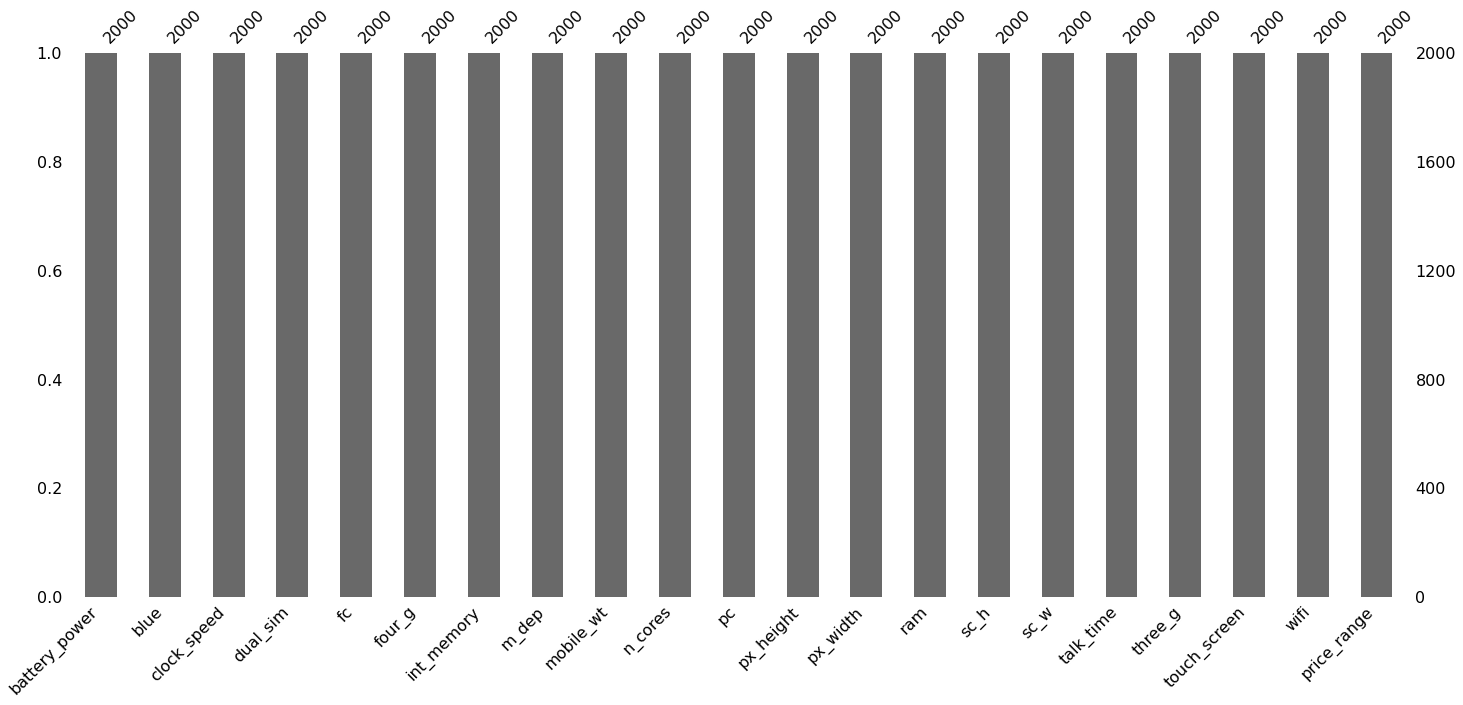

In [61]:
# Missing values
missingno.bar(train)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

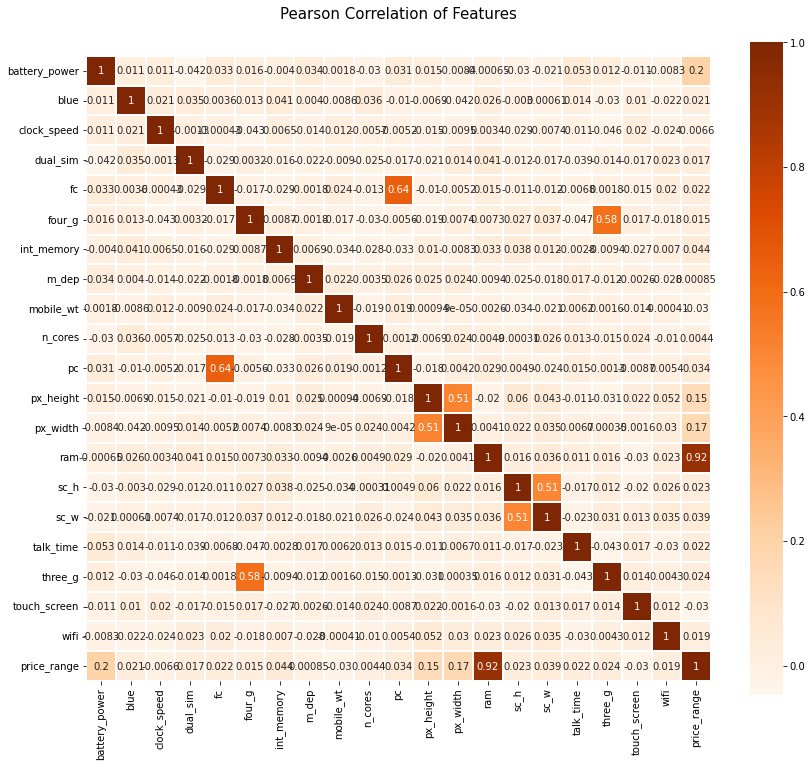

In [62]:
# How features correlate with each other
colormap = plt.cm.Oranges
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.01, 
            square=True, cmap=colormap,annot=True)



# Data Preparation

In [63]:

#separate the target variable
train_data = train.drop(columns='price_range')
train_targets  = train.price_range

data_train,data_val,target_train,target_val = train_test_split(train_data,
                                                  train_targets,
                                                  train_size=.7,
                                                  random_state=42)

x_train, x_val, y_train, y_val = train_test_split(data_train,
                                                  target_train,
                                                  train_size=.7,
                                                  random_state=42)



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Traning basic models

In [64]:
# Selection of model parameters using GridSearchCV
lr = LogisticRegression()
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,.009,0.01,.09,1],
    'solver': ['lbfgs','newton-cg','liblinear']   
}

grid_search_lr = GridSearchCV(estimator=lr,
                              param_grid=lr_params,
                              cv=skf,
                              scoring='accuracy')
grid_result_lr = grid_search_lr.fit(x_train, y_train)

# Model training and scoring
lr = lr.set_params(**grid_result_lr.best_params_)
lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_val)
print(f'LogisticRegression best params : {grid_result_lr.best_params_}')
print(f'LogisticRegression Accuracy score : {accuracy_score(y_val,y_pred_lr)}')


LogisticRegression best params : {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression Accuracy score : 0.9714964370546318


In [65]:
# Selection of model parameters using GridSearchCV
gbc = GradientBoostingClassifier(max_leaf_nodes=5,random_state=42)
gbc_params = {
    'learning_rate': np.arange(0.1, 0.6, 0.1),
}
grid_search_gbc = GridSearchCV(estimator=gbc,
                              param_grid=gbc_params,
                              cv=skf,
                               scoring='accuracy')
grid_result_gbc = grid_search_gbc.fit(x_train, y_train)

# Model training and scoring
gbc = gbc.set_params(**grid_result_gbc.best_params_)
gbc.fit(x_train, y_train)
y_pred_gbc = gbc.predict(x_val)
print(f'GradientBoostingClassifier best params : {grid_result_gbc.best_params_}')
print(f'GradientBoostingClassifier Accuracy score : {accuracy_score(y_val,y_pred_gbc)}')

GradientBoostingClassifier best params : {'learning_rate': 0.2}
GradientBoostingClassifier Accuracy score : 0.8836104513064132


In [66]:
# Selection of model parameters using GridSearchCV
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors':range(1,15,2),
    'weights':['iniform','distance'],
    'metric':['euclidian','manhattan','minkowski'],
    'leaf_size':[1,50,5]  
}

grid_search_knn = GridSearchCV(estimator=knn,
                               param_grid=knn_params,
                               cv=skf,
                               scoring='accuracy')

grid_result_knn = grid_search_knn.fit(x_train, y_train)

# Model training and scoring
knn = knn.set_params(**grid_result_knn.best_params_)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_val)
print(f'KNeighborsClassifier best params : {grid_result_knn.best_params_}')
print(f'KNeighborsClassifier Accuracy score : {accuracy_score(y_val,y_pred_knn)}')

KNeighborsClassifier best params : {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}
KNeighborsClassifier Accuracy score : 0.9239904988123515


In [67]:
# Selection of model parameters using GridSearchCV
svc = SVC()
svc_params = {
    'C': [0.1,1, 10, 100],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}
grid_search_svc = GridSearchCV(estimator=svc,
                               param_grid=svc_params,
                               cv=skf,
                               scoring='accuracy')

grid_result_svc = grid_search_svc.fit(x_train, y_train)

# Model training and scoring
svc = svc.set_params(**grid_result_svc.best_params_)
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_val)
print(f'SVC best params : {grid_result_svc.best_params_}')
print(f'SVC Accuracy score : {accuracy_score(y_val,y_pred_svc)}')

SVC best params : {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
SVC Accuracy score : 0.9406175771971497


# Training Meta Algorithm - XGBoost

In [86]:
#select params for meta algorithm,using GridSearchCV
xgb = XGBClassifier(random_state=42,cv=5, verbosity = 0,silent=True)
xgb_params = {'n_estimators': range(40, 150, 10)}

#creating a meta matrix
meta_mtrx = np.empty((x_val.shape[0],4))

meta_mtrx[:,0]=y_pred_lr
meta_mtrx[:,1]=y_pred_gbc
meta_mtrx[:,2]=y_pred_knn
meta_mtrx[:,3]=y_pred_svc


In [87]:
grid_search_xgb = GridSearchCV(estimator=xgb,
                               param_grid=xgb_params,
                               cv=skf)
model_xgb = grid_search_xgb.fit(meta_mtrx, y_val)
print(f'XGBClassifier best params :{model_xgb.best_params_}')

XGBClassifier best params :{'n_estimators': 50}


In [88]:
#staking based on algorithms with the best parameters

lr = lr.set_params(**grid_result_lr.best_params_)
gbc = gbc.set_params(**grid_result_gbc.best_params_)
knn = knn.set_params(**grid_result_knn.best_params_)
svc = svc.set_params(**grid_result_svc.best_params_)

meta_alg = xgb.set_params(**model_xgb.best_params_)

models_base=[]
models=[lr,gbc,knn,svc]
meta_mtrx = np.empty((data_train.shape[0],len(models)))

for n,model in enumerate(models):
    meta_mtrx[:,n]=cross_val_predict(model,
                                     data_train.values,
                                     target_train.values,
                                     cv=5,method='predict')
    model_base = model.fit(data_train,target_train)
    models_base.append(model_base)
    
meta_model = meta_alg.fit(meta_mtrx,target_train)


meta_mtrx_test = np.empty((data_val.shape[0],len(models)))

for n,model in enumerate(models):
    meta_mtrx_test[:,n]=model.predict(data_val)

meta_predict = meta_model.predict(meta_mtrx_test)

In [89]:
print(f'Meta Algorithm - XGBoost Accuracy score : {accuracy_score(target_val,meta_predict)}')


Meta Algorithm - XGBoost Accuracy score : 0.975


In [93]:
meta_mtrx_test = np.empty((test.shape[0],len(models)))

for n,model in enumerate(models):
    meta_mtrx_test[:,n]=model.predict(test)

meta_predict_test = meta_model.predict(meta_mtrx_test)

In [94]:
meta_predict_test

array([3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2, 1, 3,
       1, 1, 3, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 1, 3, 1, 2, 1, 1, 2, 0, 0,
       0, 1, 0, 3, 1, 2, 1, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 3, 0, 1, 0, 1,
       2, 3, 1, 2, 1, 2, 2, 3, 3, 0, 2, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1,
       3, 0, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 3, 0, 2, 0, 1, 2, 3,
       3, 3, 1, 3, 3, 3, 3, 2, 3, 0, 0, 3, 2, 1, 2, 0, 3, 2, 2, 2, 0, 2,
       2, 1, 3, 1, 1, 0, 3, 2, 1, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 3, 1, 0,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 2, 1, 0, 1,
       0, 0, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0, 0, 1, 0, 3, 1, 0, 2, 2,
       3, 3, 1, 2, 3, 2, 3, 2, 2, 1, 1, 0, 1, 2, 1, 2, 3, 3, 0, 2, 0, 3,
       2, 3, 3, 1, 0, 1, 0, 3, 0, 1, 0, 2, 2, 1, 3, 1, 3, 0, 3, 1, 2, 0,
       0, 2, 1, 3, 3, 3, 1, 1, 3, 0, 0, 2, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2,
       3, 3, 3, 1, 0, 1, 2, 3, 1, 1, 3, 2, 0, 3, 0, 0, 2, 0, 0, 3, 2, 3,
       3, 2, 1, 3, 3, 2, 3, 1, 2, 1, 2, 0, 2, 3, 1,